In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class AgeDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu1/age/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["20-30s", "40-50s", "baby", "kid", "senior", "teenager"]
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu1/age/'
train_dataset = AgeDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = AgeDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

27783
3058


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

class MyResnet(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        del self.backbone.fc
#         self.fc1 = nn.Linear(2048, 1000)
#         self.drouput1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1000, 2)
        self.fc = nn.Linear(2048, 6)#n_classes)
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)

        x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.drouput1(x)
#         x = self.fc2(x)
        x = self.fc(x)
#         x = nn.Sigmoid()(x)
        return x

In [5]:
x = torch.randn(16, 3, 224, 224)
model = MyResnet()
# print(model)
print(model(x).shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


torch.Size([16, 6])


In [6]:
import torch.optim as optim
from tqdm import tqdm
epochs = 40
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

In [7]:
train_dataset = AgeDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = AgeDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

27783
3058


In [8]:
model = MyResnet().to(device)
if os.path.exists('last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('last.pt'))
    else:
        model.load_state_dict(torch.load('last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) 

In [9]:
best_acc = 0
best_model = MyResnet().to(device)
if os.path.exists('best.pt'):
    best_model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [10]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/40 Iter: 3473 Loss: 0.7790: 100%|██████████| 3473/3473 [03:16<00:00, 17.70it/s]


Epoch: 1/40 Test Loss: 0.5037 Test Acc: 0.8198


Epoch: 2/40 Iter: 3473 Loss: 0.1858: 100%|██████████| 3473/3473 [03:12<00:00, 18.03it/s]


Epoch: 2/40 Test Loss: 0.2495 Test Acc: 0.8313


Epoch: 3/40 Iter: 3473 Loss: 0.6835: 100%|██████████| 3473/3473 [03:12<00:00, 18.04it/s]


Epoch: 3/40 Test Loss: 1.5314 Test Acc: 0.8506


Epoch: 4/40 Iter: 3473 Loss: 0.2661: 100%|██████████| 3473/3473 [03:13<00:00, 17.97it/s]


Epoch: 4/40 Test Loss: 0.0972 Test Acc: 0.8450


Epoch: 5/40 Iter: 3473 Loss: 0.0041: 100%|██████████| 3473/3473 [03:12<00:00, 18.05it/s]


Epoch: 5/40 Test Loss: 0.1749 Test Acc: 0.8394


Epoch: 6/40 Iter: 3473 Loss: 0.0408: 100%|██████████| 3473/3473 [03:12<00:00, 18.03it/s]


Epoch: 6/40 Test Loss: 0.1191 Test Acc: 0.8555


Epoch: 7/40 Iter: 3473 Loss: 0.0029: 100%|██████████| 3473/3473 [03:12<00:00, 18.03it/s]


Epoch: 7/40 Test Loss: 0.9944 Test Acc: 0.8551


Epoch: 8/40 Iter: 3473 Loss: 0.0112: 100%|██████████| 3473/3473 [03:12<00:00, 18.03it/s]


Epoch: 8/40 Test Loss: 0.3356 Test Acc: 0.8551


Epoch: 9/40 Iter: 3473 Loss: 0.0013: 100%|██████████| 3473/3473 [03:13<00:00, 17.99it/s]


Epoch: 9/40 Test Loss: 1.2590 Test Acc: 0.8538


Epoch: 10/40 Iter: 3473 Loss: 0.0044: 100%|██████████| 3473/3473 [03:13<00:00, 17.97it/s]


Epoch: 10/40 Test Loss: 1.4323 Test Acc: 0.8597


Epoch: 11/40 Iter: 3473 Loss: 0.0412: 100%|██████████| 3473/3473 [03:13<00:00, 17.96it/s]


Epoch: 11/40 Test Loss: 0.1629 Test Acc: 0.8568


Epoch: 12/40 Iter: 3473 Loss: 0.0005: 100%|██████████| 3473/3473 [03:13<00:00, 17.92it/s]


Epoch: 12/40 Test Loss: 1.0623 Test Acc: 0.8649


Epoch: 13/40 Iter: 3473 Loss: 0.0012: 100%|██████████| 3473/3473 [03:13<00:00, 17.98it/s]


Epoch: 13/40 Test Loss: 0.5362 Test Acc: 0.8591


Epoch: 14/40 Iter: 3473 Loss: 0.0022: 100%|██████████| 3473/3473 [03:13<00:00, 17.98it/s]


Epoch: 14/40 Test Loss: 0.0080 Test Acc: 0.8633


Epoch: 15/40 Iter: 3473 Loss: 0.0005: 100%|██████████| 3473/3473 [03:12<00:00, 18.01it/s]


Epoch: 15/40 Test Loss: 0.9468 Test Acc: 0.8636


Epoch: 16/40 Iter: 3473 Loss: 0.0004: 100%|██████████| 3473/3473 [03:13<00:00, 17.97it/s]


Epoch: 16/40 Test Loss: 0.0839 Test Acc: 0.8535


Epoch: 17/40 Iter: 3473 Loss: 0.0015: 100%|██████████| 3473/3473 [03:13<00:00, 17.98it/s]


Epoch: 17/40 Test Loss: 0.0089 Test Acc: 0.8689


Epoch: 18/40 Iter: 3473 Loss: 0.0010: 100%|██████████| 3473/3473 [03:13<00:00, 17.95it/s]


Epoch: 18/40 Test Loss: 0.0510 Test Acc: 0.8617


Epoch: 19/40 Iter: 3473 Loss: 0.0030: 100%|██████████| 3473/3473 [03:13<00:00, 17.98it/s]


Epoch: 19/40 Test Loss: 0.0024 Test Acc: 0.8679


Epoch: 20/40 Iter: 3473 Loss: 0.0004: 100%|██████████| 3473/3473 [03:12<00:00, 18.00it/s]


Epoch: 20/40 Test Loss: 0.0057 Test Acc: 0.8597


Epoch: 21/40 Iter: 3473 Loss: 0.0011: 100%|██████████| 3473/3473 [03:13<00:00, 17.95it/s]


Epoch: 21/40 Test Loss: 0.2711 Test Acc: 0.8643


Epoch: 22/40 Iter: 3473 Loss: 0.0165: 100%|██████████| 3473/3473 [03:13<00:00, 17.96it/s]


Epoch: 22/40 Test Loss: 0.2305 Test Acc: 0.8594


Epoch: 23/40 Iter: 3473 Loss: 0.0004: 100%|██████████| 3473/3473 [03:13<00:00, 17.97it/s]


Epoch: 23/40 Test Loss: 0.0026 Test Acc: 0.8545


Epoch: 24/40 Iter: 3473 Loss: 0.0002: 100%|██████████| 3473/3473 [03:12<00:00, 18.00it/s]


Epoch: 24/40 Test Loss: 0.1590 Test Acc: 0.8705


Epoch: 25/40 Iter: 3473 Loss: 0.0105: 100%|██████████| 3473/3473 [03:12<00:00, 18.01it/s]


Epoch: 25/40 Test Loss: 0.5331 Test Acc: 0.8656


Epoch: 26/40 Iter: 3473 Loss: 0.0304: 100%|██████████| 3473/3473 [03:12<00:00, 18.03it/s]


Epoch: 26/40 Test Loss: 0.8794 Test Acc: 0.8669


Epoch: 27/40 Iter: 3473 Loss: 0.0018: 100%|██████████| 3473/3473 [03:12<00:00, 18.02it/s]


Epoch: 27/40 Test Loss: 0.2160 Test Acc: 0.8666


Epoch: 28/40 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [03:12<00:00, 18.00it/s]


Epoch: 28/40 Test Loss: 1.9424 Test Acc: 0.8663


Epoch: 29/40 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [03:12<00:00, 18.04it/s]


Epoch: 29/40 Test Loss: 0.3660 Test Acc: 0.8633


Epoch: 30/40 Iter: 3473 Loss: 0.0003: 100%|██████████| 3473/3473 [03:12<00:00, 18.02it/s]


Epoch: 30/40 Test Loss: 0.2597 Test Acc: 0.8669


Epoch: 31/40 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [03:12<00:00, 18.04it/s]


Epoch: 31/40 Test Loss: 0.0820 Test Acc: 0.8633


Epoch: 32/40 Iter: 3473 Loss: 0.0021: 100%|██████████| 3473/3473 [03:12<00:00, 18.01it/s]


Epoch: 32/40 Test Loss: 1.6610 Test Acc: 0.8653


Epoch: 33/40 Iter: 3473 Loss: 0.0018: 100%|██████████| 3473/3473 [03:13<00:00, 17.97it/s]


Epoch: 33/40 Test Loss: 1.6235 Test Acc: 0.8646


Epoch: 34/40 Iter: 3473 Loss: 0.0025: 100%|██████████| 3473/3473 [03:12<00:00, 18.00it/s]


Epoch: 34/40 Test Loss: 0.1866 Test Acc: 0.8715


Epoch: 35/40 Iter: 3473 Loss: 0.0002: 100%|██████████| 3473/3473 [03:12<00:00, 18.02it/s]


Epoch: 35/40 Test Loss: 2.4464 Test Acc: 0.8649


Epoch: 36/40 Iter: 3473 Loss: 0.0002: 100%|██████████| 3473/3473 [03:12<00:00, 18.01it/s]


Epoch: 36/40 Test Loss: 0.1599 Test Acc: 0.8659


Epoch: 37/40 Iter: 3473 Loss: 0.0003: 100%|██████████| 3473/3473 [03:13<00:00, 17.99it/s]


Epoch: 37/40 Test Loss: 1.4225 Test Acc: 0.8646


Epoch: 38/40 Iter: 3473 Loss: 0.0003: 100%|██████████| 3473/3473 [03:13<00:00, 17.99it/s]


Epoch: 38/40 Test Loss: 1.7147 Test Acc: 0.8653


Epoch: 39/40 Iter: 3473 Loss: 0.0004: 100%|██████████| 3473/3473 [03:12<00:00, 18.01it/s]


Epoch: 39/40 Test Loss: 3.8174 Test Acc: 0.8636


Epoch: 40/40 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [03:13<00:00, 17.99it/s]


Epoch: 40/40 Test Loss: 3.9354 Test Acc: 0.8633


In [11]:
test_model = MyResnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyResnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [12]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["20-30s", "40-50s", "baby", "kid", "senior", "teenager"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[1175, 1660, 2225, 1822, 3014, 2714, 995, 297]
torch.Size([8, 3, 224, 224])
[0, 0, 1, 0, 5, 3, 0, 0]
tensor([3, 1, 1, 0, 0, 3, 0, 0])


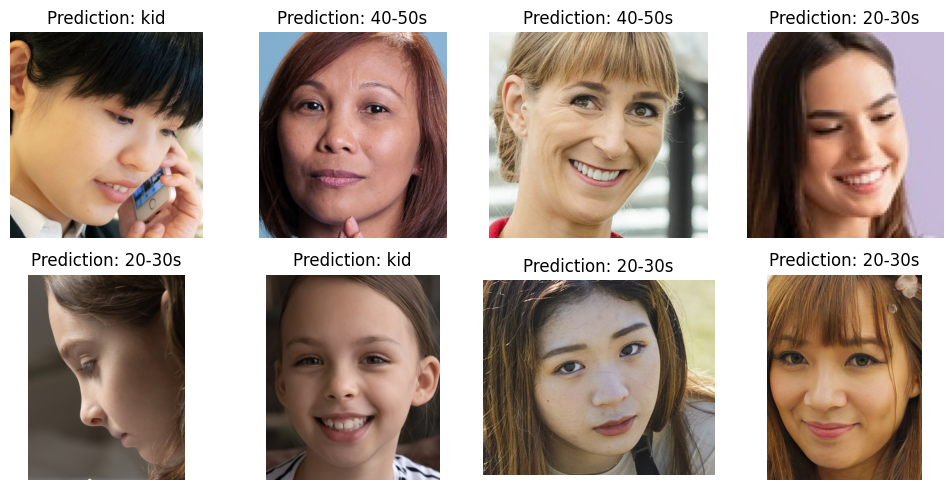

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()